In [1]:
import sys
import subprocess
import os 

import glob
import multiprocessing

In [2]:
sys.path.append('../../')
from extract_glycan_info import parse_gf_result

Script: Find glycosidic dihedral, average B-factor, and ring shape of glycans from PDB
Author:Rajan Kandel <rajan.kandel@uga.edu>
      *Woods Group, CCRC UGA
  
Currently under development.......
Last Update: Oct 2024

Citations:
1. https://glycam.org/cb/
2. https://glycam.org/portal/gf_home/
 


In [3]:
phi_dihedral=['C2','C1','O6','C6']
psi_dihedral=['C1','O6','C6','C5']

di_sugar=['GLC', 'NDG']
di_sugar2= ['DGlcpa', 'DGlcpNAca']
link= '1-6'
patterns1= [di_sugar[0]+'(*_*_)]-'+di_sugar[1]+'(*_*_)', di_sugar[0]+'(*_*_)-'+di_sugar[1]+'(*_*_)',di_sugar[0]+'(*_*_)]-[*]-'+di_sugar[1]+'(*_*_)', di_sugar[0]+'(*_*_)-[*]-'+di_sugar[1]+'(*_*_)']
patterns2= [di_sugar2[0]+link+di_sugar2[1], di_sugar2[0]+link+']'+di_sugar2[1], di_sugar2[0]+link+'[*]'+di_sugar2[1]]
patterns=(patterns1,patterns2)

gf_result ='../../data_gf_query/a1-6D_GF_results.csv'

chimerax_path= '/bin/chimerax'
bfmp_path = '/home/rajan/apps/BFMP/detect_shape'


instant1 = parse_gf_result(gf_result, phi_dihedral, psi_dihedral, di_sugar, patterns, chimerax_path, bfmp_path)
instant1.read_gf_file()
instant1.dnl_pdbs()
instant1.create_pdb_glycan_dict() 
instant1.glycan_count()
instant1.select_pdbs()

========== Reading_gf_results =====================================
pdbs: ['1A7C', '1ABR', '1ABR', '1AGM', '1AH1', '1AU1', '1AU1', '1AX0', '1AX1', '1AX2', '1AXY', '1AXZ', '1B0F', '1B0F', '1B37', '1B41', '1B5F', '1B5Q', '1BHG', '1BHG', '1BLF', '1BRR', '1BRR', '1BZB', '1C1Z', '1CDR', '1CF5', '1CF5', '1CKL', '1CKL', '1CKL', '1CKL', '1CPO', '1CVI', '1CVI', '1CVI', '1CVI', '1CVN', '1CVN', '1CVN', '1CVN', '1CVU', '1CVU', '1CXP', '1CXP', '1D2V', '1D2V', '1D5L', '1D5L', '1D7W', '1D7W', '1DEO', '1DEX', '1DGL', '1DGL', '1DIY', '1DL2', '1DN2', '1DN2', '1DNU', '1DNU', '1DNW', '1DNW', '1DOG', '1DP5', '1DPJ', '1DWA', '1DWF', '1DWG', '1DWH', '1DWI', '1DWJ', '1DZE', '1E04', '1E05', '1E4K', '1E4K', '1E6Q', '1E6S', '1EOM', '1ETH', '1ETH', '1EX1', '1F6A', '1F6A', '1F6A', '1F6A', '1F8B', '1F8C', '1F8D', '1F8E', '1F8R', '1F8R', '1F8R', '1FC1', '1FC1', '1FC2', '1FE2', '1FE8', '1FE8', '1FE8', '1FI1', '1FRT', '1FRT', '1FUJ', '1FUJ', '1FUJ', '1FUJ', '1FX5', '1FZD', '1FZD', '1FZD', '1FZD', '1G0V', '1G6I', '1G6I

In [4]:
%%capture output
instant1.generate_chimerax_script_to_compute_dihedral()

In [5]:
# Write the entire output to a file
with open('calc_dihedral2.cxc', 'w') as f:
    f.write(output.stdout)

In [6]:
# Use the custom split function
instant1.custom_split_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral_part_')

chimerax script is run parallely in ./calc_dihedral_chimerax
Split into 1 files.


In [7]:
# Run the parallel execution and stitching
instant1.run_chimerax_script_parallel('./calc_dihedral_chimerax/calc_dihedral_part_*.cxc')

Executed 1 ChimeraX scripts in parallel.
Combined outputs into:  combined_chimerax_output.out


In [8]:
# instant1.run_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral2.out')

In [9]:
# torsions = instant1.clean_up_chimerax_output('calc_dihedral2.out')
torsions = instant1.clean_up_chimerax_output('combined_chimerax_output.out')
torsions.to_csv('chimerax_output.csv', index=False)

number of pdb read: 4 
valid torsion1 and torsion2: (4, 4)


In [10]:
instant1.calc_BFactor()

In [11]:
instant1.find_bfmp_ring_shape()

(['6.B', '1.B'], ['4C1', '4C1'])
(['3.B', '1.B'], ['4C1', '4C1'])
(['6.B', '1.B'], ['4C1', '4C1'])
(['3.B', '1.B'], ['4C1', '4C1'])


In [12]:
output_df = instant1.match_glycan_tree()

../../pdbs//6gvp.pdb B GLC 6 C1
../../pdbs//6gvp.pdb B NDG 1 O6
4699 4649
Connection found between 4699 and 4649
../../pdbs//6gvp.pdb B GLC 3 C1
../../pdbs//6gvp.pdb B NDG 1 O6
4664 4649
No connection found between 4664 and 4649
1
../../pdbs//4xle.pdb B GLC 6 C1
../../pdbs//4xle.pdb B NDG 1 O6
4779 4729
Connection found between 4779 and 4729
../../pdbs//4xle.pdb B GLC 3 C1
../../pdbs//4xle.pdb B NDG 1 O6
4744 4729
No connection found between 4744 and 4729
3
droped rows: [1, 3]


In [13]:
outfile_name = di_sugar2[0]+link+di_sugar2[1]

In [14]:
output_df.to_csv(outfile_name+'_ver2.1.csv',sep=',',index=False, columns=['pdb','glycam name','glycan','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])
output_df.to_csv(outfile_name+'_ver3.csv',sep=',',index=False, columns=['pdb','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])

In [15]:
################################
# print(instant1.pdbs)
# print(instant1.pdb_glycan_dict)

In [16]:
instant1.torsions

,pdb,phi site,psi site,phi,psi,B factor(Avg),glycan,glycam name,BFMP ring shape
0,6gvp.pdb,B GLC 6 C2 C1 NDG 1 O6 C6,B GLC 6 C1 NDG 1 O6 C6 C5,194.084,86.1567,"([GLC(6_B_), NDG(1_B_)], [21.37, 16.25])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([6.B, 1.B], [4C1, 4C1])"
1,6gvp.pdb,B GLC 3 C2 C1 NDG 1 O6 C6,B GLC 3 C1 NDG 1 O6 C6 C5,148.208,34.2375,"([GLC(3_B_), NDG(1_B_)], [19.5, 16.25])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([3.B, 1.B], [4C1, 4C1])"
2,4xle.pdb,B GLC 6 C2 C1 NDG 1 O6 C6,B GLC 6 C1 NDG 1 O6 C6 C5,188.681,87.8635,"([GLC(6_B_), NDG(1_B_)], [10.92, 11.48])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([6.B, 1.B], [4C1, 4C1])"
3,4xle.pdb,B GLC 3 C2 C1 NDG 1 O6 C6,B GLC 3 C1 NDG 1 O6 C6 C5,138.799,30.0137,"([GLC(3_B_), NDG(1_B_)], [17.53, 11.48])",GLC(6_B_)-[RAM(4_B_)-GLC(3_B_)-[NAG(5_B_)]-GLA...,LRhapa1-6DGlcpa1-4[DGlcpNAcb1-3]DGalpa1-3[DGlc...,"([3.B, 1.B], [4C1, 4C1])"


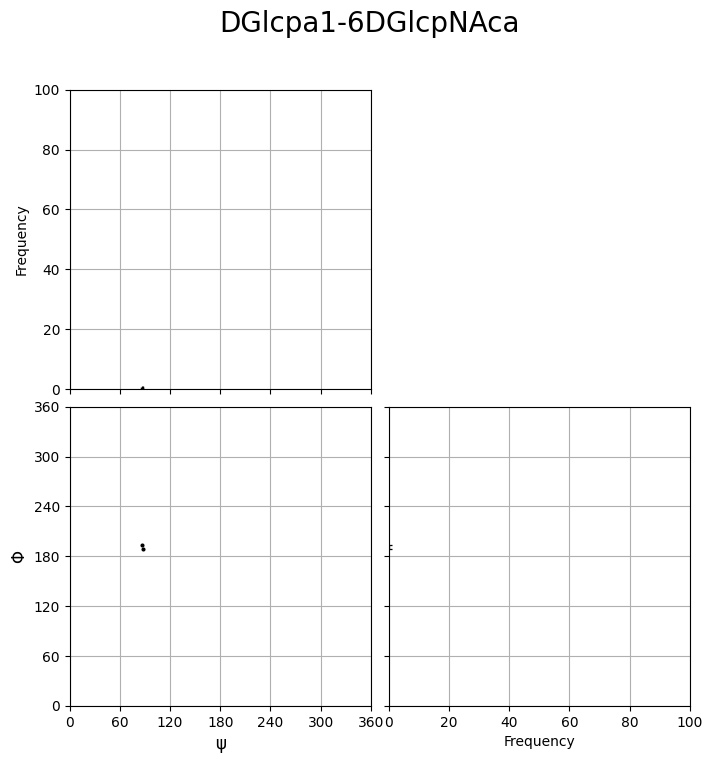

In [17]:
instant1.plot(torsions=output_df, title=outfile_name,max_histogram_scale=100,step_histogram_tick=20)